In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, r2_score
from elofooot import EloRating
from h2h_features import add_h2h_features
r2_score


#charger le fichier si present si pas present le creer :
try :
    liga1 =pd.read_csv("C:/Users/USER/Documents/projet&code/datasets/football/liga1/liga1024.csv")
except FileNotFoundError :
    fichiers = {
        "C:/Users/USER/Documents/projet&code/datasets/football/liga1/SP12011.csv": "2011/2012",
        "C:/Users/USER/Documents/projet&code/datasets/football/liga1/SP12011.csv": "2011/2012",
        "C:/Users/USER/Documents/projet&code/datasets/football/liga1/SP12012.csv": "2012/2013",
        "C:/Users/USER/Documents/projet&code/datasets/football/liga1/SP12013.csv": "2013/2014",
        "C:/Users/USER/Documents/projet&code/datasets/football/liga1/SP12014.csv": "2014/2015",
        "C:/Users/USER/Documents/projet&code/datasets/football/liga1/SP12015.csv": "2015/2016",
        "C:/Users/USER/Documents/projet&code/datasets/football/liga1/SP12016.csv": "2016/2017",
        "C:/Users/USER/Documents/projet&code/datasets/football/liga1/SP12017.csv": "2017/2018",
        "C:/Users/USER/Documents/projet&code/datasets/football/liga1/SP12018.csv": "2018/2019",
        "C:/Users/USER/Documents/projet&code/datasets/football/liga1/SP12019.csv": "2019/2020",
        "C:/Users/USER/Documents/projet&code/datasets/football/liga1/SP12020.csv": "2020/2021",
        "C:/Users/USER/Documents/projet&code/datasets/football/liga1/SP12021.csv": "2021/2022",
        "C:/Users/USER/Documents/projet&code/datasets/football/liga1/SP12022.csv": "2022/2023",
        "C:/Users/USER/Documents/projet&code/datasets/football/liga1/SP12023.csv": "2023/2024",
        "C:/Users/USER/Documents/projet&code/datasets/football/liga1/SP12024.csv": "2024/2025"
    }

    # Liste pour stocker les DataFrames
    dfs = []

    # Charger les fichiers un par un
    for fichier, saison in fichiers.items():
        df = pd.read_csv(fichier)
        df["Saison"] = saison  # Ajouter la saison dans une nouvelle colonne
        dfs.append(df)

    # Fusionner tous les DataFrames en un seul
    liga1 = pd.concat(dfs, ignore_index=True)
    #creer le fichier
    liga1.to_csv("C:/Users/USER/Documents/projet&code/datasets/football/liga1/liga1024.csv", index=False)




In [2]:
colonnes_utiles = [
    'Date','HomeTeam','AwayTeam',
    'FTHG','FTAG','FTR',
    'HTHG','HTAG','HTR',
    'HS','AS','HST','AST',
    'HF','AF','HC','AC',
    'HY','AY','HR','AR','B365H','B365D','B365A'
]


In [3]:
#enlever les lignes inutiles
liga1= liga1[colonnes_utiles]
print(liga1.shape)
#gerer la date en int
##
liga1['Date'] = pd.to_datetime(liga1['Date'])
liga1['Month'] = liga1['Date'].dt.month
liga1['Day'] = liga1['Date'].dt.day
liga1['Year'] = liga1['Date'].dt.year
# First, ensure 'Year', 'Month', and 'Day' are integers
liga1[['Year', 'Month', 'Day']] = liga1[['Year', 'Month', 'Day']].astype(int)
liga1['Date'] = liga1['Year'] * 10000 + liga1['Month'] * 100 + liga1['Day']
liga1=liga1.sort_values('Date') # sort les values de la date
# Drop the the table less unused :
liga1=liga1.drop(columns=['Day','Month', 'Year'])
print(liga1)

(5119, 24)
          Date     HomeTeam    AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR  HS  \
89    20100111     Mallorca     Levante     2     1   H     0     1   A  22   
52    20100210     Zaragoza    Sp Gijon     2     2   D     0     1   A   9   
51    20100210     Valencia  Ath Bilbao     2     1   H     1     0   H  18   
50    20100210     Sociedad     Espanol     1     0   H     0     0   D  18   
56    20100310      Osasuna     Levante     1     1   D     0     0   D  18   
...        ...          ...         ...   ...   ...  ..   ...   ...  ..  ..   
5115  20241221    Barcelona  Ath Madrid     1     2   A     1     0   H  19   
5114  20241221      Osasuna  Ath Bilbao     1     2   A     1     1   D   6   
5118  20241222   Las Palmas     Espanol     1     0   H     0     0   D  10   
5117  20241222  Real Madrid     Sevilla     4     2   H     3     1   H  16   
5116  20241222     Valencia      Alaves     2     2   D     0     1   A   8   

      ...  AF  HC  AC  HY  AY  HR  AR  B

C:\Users\USER\AppData\Local\Temp\ipykernel_1444\3449404799.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  liga1['Date'] = pd.to_datetime(liga1['Date'])


In [4]:
#initialisation de l'elo
elo = EloRating()
# Colonnes à remplir
elo_home = []
elo_away = []
for _, row in liga1.iterrows():
    home = row['HomeTeam']
    away = row['AwayTeam']
    result = row['FTR']  # "H", "A", "D"

    # Obtenir rating AVANT match
    elo_home.append(elo.get_rating(home))
    elo_away.append(elo.get_rating(away))

    # Mettre à jour le score ELO selon résultat
    elo.update_ratings(home, away, result)

# Ajouter les colonnes ELO
liga1['elo_home'] = elo_home
liga1['elo_away'] = elo_away
liga1['diff_elo'] = liga1['elo_home'] - liga1['elo_away']
#ajout du head to head
liga1 = add_h2h_features(liga1)

creer les collonnes des données que l'on va utiliser pour predire dans le dataset(moyenne glissante, moyenne des tirs cadré des 3 dernier match, tir cadré du dernier match, moyenne de corner, moyenne de carton jaune, ect ect)

In [5]:

def addstat(): #ajouter les statistiques interessantes pour l'apprentisage 
    #creer les moyennes glissantes pour pouvoir analyser les performances passées
    # Moyenne des tirs pour équipe à domicile
    liga1['HS_avg'] = liga1.groupby('HomeTeam')['HS'].transform(lambda x: x.shift(1).rolling(4).mean())
    # Moyenne des tirs pour équipe à l'extérieur
    liga1['AS_avg'] = liga1.groupby('AwayTeam')['AS'].transform(lambda x: x.shift(1).rolling(4).mean())
    #moyenne des buts
    liga1['FTHG_avg'] = liga1.groupby('HomeTeam')['FTHG'].transform(lambda x: x.shift(1).rolling(4).mean())
    # Moyenne des tirs pour équipe à l'extérieur
    liga1['FTAG_avg'] = liga1.groupby('AwayTeam')['FTAG'].transform(lambda x: x.shift(1).rolling(4).mean())
    liga1['HST_avg'] = liga1.groupby('HomeTeam')['HST'].transform(lambda x: x.shift(1).rolling(4).mean())
    # Moyenne des tirs cibles pour équipe à l'extérieur
    liga1['AST_avg'] = liga1.groupby('AwayTeam')['AST'].transform(lambda x: x.shift(1).rolling(4).mean())
    #moyenne des buts à  domicile
    # Moyenne des corners pour équipe à domicile
    liga1['HC_avg'] = liga1.groupby('HomeTeam')['HC'].transform(lambda x: x.shift(1).rolling(4).mean())
    # Moyenne des corners pour équipe à l'extérieur
    liga1['AC_avg'] = liga1.groupby('AwayTeam')['AC'].transform(lambda x: x.shift(1).rolling(4).mean())

    # Moyenne des fautes pour équipe à domicile
    liga1['HF_avg'] = liga1.groupby('HomeTeam')['HF'].transform(lambda x: x.shift(1).rolling(4).mean())
    # Moyenne des fautes pour équipe à l'extérieur
    liga1['AF_avg'] = liga1.groupby('AwayTeam')['AF'].transform(lambda x: x.shift(1).rolling(4).mean())

    # Moyenne des cartons jaunes pour équipe à domicile
    liga1['HY_avg'] = liga1.groupby('HomeTeam')['HY'].transform(lambda x: x.shift(1).rolling(4).mean())
    # Moyenne des cartons jaunes pour équipe à l'extérieur
    liga1['AY_avg'] = liga1.groupby('AwayTeam')['AY'].transform(lambda x: x.shift(1).rolling(4).mean())

    # Moyenne des cartons rouges pour équipe à domicile
    liga1['HR_avg'] = liga1.groupby('HomeTeam')['HR'].transform(lambda x: x.shift(1).rolling(4).mean())
    # Moyenne des cartons rouges pour équipe à l'extérieur
    liga1['AR_avg'] = liga1.groupby('AwayTeam')['AR'].transform(lambda x: x.shift(1).rolling(4).mean())
    #bilan des 5 derniers match
    
addstat()
adropna = ["HS_avg", "AS_avg", "FTHG_avg", "FTAG_avg", "HST_avg", "AST_avg", "HC_avg", "AC_avg", "HF_avg", "AF_avg",
"HY_avg", "AY_avg", "HR_avg", "AR_avg"]
print(liga1)


                              Date     HomeTeam    AwayTeam  FTHG  FTAG FTR  \
89   1970-01-01 00:00:00.020100111     Mallorca     Levante     2     1   H   
52   1970-01-01 00:00:00.020100210     Zaragoza    Sp Gijon     2     2   D   
51   1970-01-01 00:00:00.020100210     Valencia  Ath Bilbao     2     1   H   
50   1970-01-01 00:00:00.020100210     Sociedad     Espanol     1     0   H   
56   1970-01-01 00:00:00.020100310      Osasuna     Levante     1     1   D   
...                            ...          ...         ...   ...   ...  ..   
5113 1970-01-01 00:00:00.020241221        Celta    Sociedad     2     0   H   
5114 1970-01-01 00:00:00.020241221      Osasuna  Ath Bilbao     1     2   A   
5117 1970-01-01 00:00:00.020241222  Real Madrid     Sevilla     4     2   H   
5118 1970-01-01 00:00:00.020241222   Las Palmas     Espanol     1     0   H   
5116 1970-01-01 00:00:00.020241222     Valencia      Alaves     2     2   D   

      HTHG  HTAG HTR  HS  ...  HST_avg  AST_avg  HC

In [6]:
# netoyage des donnes
liga1["HST"] = liga1["HST"].fillna(0)
liga1["AST"] = liga1["AST"].fillna(0)
liga1["HF"] = liga1["HF"].fillna(0)
liga1["AF"] = liga1["AF"].fillna(0)
liga1 =liga1.dropna(subset=adropna)
print(liga1)

# Supprimer les lignes sans issue de match (FTR)
liga1 = liga1.dropna(subset=["FTR"])
print(liga1.head(3))
print(liga1.shape)
print(liga1.columns)

liga1.to_csv("C:/Users/USER/Documents/projet&code/datasets/football/liga1/cleanedliga.csv", index=False)
print(liga1.head(3))
print(liga1.shape)
print(liga1.columns)

                              Date     HomeTeam     AwayTeam  FTHG  FTAG FTR  \
70   1970-01-01 00:00:00.020101023  Real Madrid    Santander     6     1   H   
73   1970-01-01 00:00:00.020101024      Almeria     Hercules     1     1   D   
75   1970-01-01 00:00:00.020101024       Getafe     Sp Gijon     3     0   H   
78   1970-01-01 00:00:00.020101024   Villarreal   Ath Madrid     2     0   H   
81   1970-01-01 00:00:00.020101030     Hercules  Real Madrid     1     3   A   
...                            ...          ...          ...   ...   ...  ..   
5113 1970-01-01 00:00:00.020241221        Celta     Sociedad     2     0   H   
5114 1970-01-01 00:00:00.020241221      Osasuna   Ath Bilbao     1     2   A   
5117 1970-01-01 00:00:00.020241222  Real Madrid      Sevilla     4     2   H   
5118 1970-01-01 00:00:00.020241222   Las Palmas      Espanol     1     0   H   
5116 1970-01-01 00:00:00.020241222     Valencia       Alaves     2     2   D   

      HTHG  HTAG HTR  HS  ...  HST_avg 

In [7]:
# liga1.to_csv("C:/Users/USER/Documents/projet&code/datasets/football/liga1/liga1824.csv", index=False)
#Save the file

encodage 

In [8]:
liga1 = pd.get_dummies(liga1, columns=["HomeTeam", "AwayTeam"], drop_first=True)
colladrop =["HS", "AS", "HST", "AST", "HHW", "AHW", "HC", "AC", "HF", "AF", "HY", "AY", "HR",
"AR", "FTR","HTR","FTAG", "HTAG", "FTHG", "HTHG", "Date"]
# Définir X et y
y = liga1["FTR"].map({"H": 0, "D": 1, "A": 2})  # cible
X = liga1.drop(columns=colladrop, errors="ignore")  # variables d'entrée

pca


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
n_components = 30
pca = PCA(n_components=n_components)
X_train_reduced = pca.fit_transform(X_train)


apprentisage

In [10]:


model_pca = RandomForestClassifier(n_estimators=100, random_state=42)
# model_pca = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(1000, 2), random_state=2)
   # Fit the model on the reduced training data
model_pca.fit(X_train_reduced, y_train)

RandomForestClassifier(random_state=42)

In [15]:
# #evaluer le modele
X_test_reduced = pca.transform(X_test)
y_pred_pca = model_pca.predict(X_test_reduced)
print(r2_score(y_test, y_pred_pca))
print("Accuracy with pca :", accuracy_score(y_test, y_pred_pca))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred_pca))
print("Rapport de classification :")
print(classification_report(y_test, y_pred_pca))


-0.534351796790627
Accuracy with pca : 0.5274390243902439
Matrice de confusion :
[[398  23  55]
 [170  17  68]
 [137  12 104]]
Rapport de classification :
              precision    recall  f1-score   support

           0       0.56      0.84      0.67       476
           1       0.33      0.07      0.11       255
           2       0.46      0.41      0.43       253

    accuracy                           0.53       984
   macro avg       0.45      0.44      0.41       984
weighted avg       0.48      0.53      0.47       984



In [12]:
importances = model_pca.feature_importances_
feature_names = ['PC' + str(i+1) for i in range(n_components)]
sorted_indices = importances.argsort()
sorted_feature_importance = [(feature_names[i], importances[i]) for i in range(len(feature_names))]
sorted_feature_importance.sort(key=lambda x: x[1], reverse=True)
for feature, score in sorted_feature_importance:
       print(f"{feature}: {score}")


PC1: 0.07855069672758924
PC3: 0.04406279707272053
PC8: 0.03565232593552791
PC2: 0.03475160467325598
PC24: 0.034189760746501256
PC5: 0.034144123280833744
PC9: 0.0338339726992974
PC18: 0.033775590796133736
PC20: 0.0324785861080413
PC22: 0.03224575484488537
PC4: 0.032130060333891805
PC16: 0.03169741755319275
PC21: 0.03157560016494624
PC14: 0.031155640124143447
PC7: 0.030827460522413693
PC26: 0.030817238244671804
PC19: 0.030666337085949708
PC27: 0.030604518125770662
PC6: 0.030597242617587717
PC29: 0.030537433061859146
PC12: 0.03029285820165512
PC11: 0.030223617766568053
PC13: 0.030200350267761168
PC28: 0.029737614060076537
PC10: 0.029681928630841584
PC15: 0.02952694488422696
PC30: 0.029269384346351193
PC23: 0.028990261868708168
PC25: 0.02892105520631602
PC17: 0.028861824048281744


plot importance

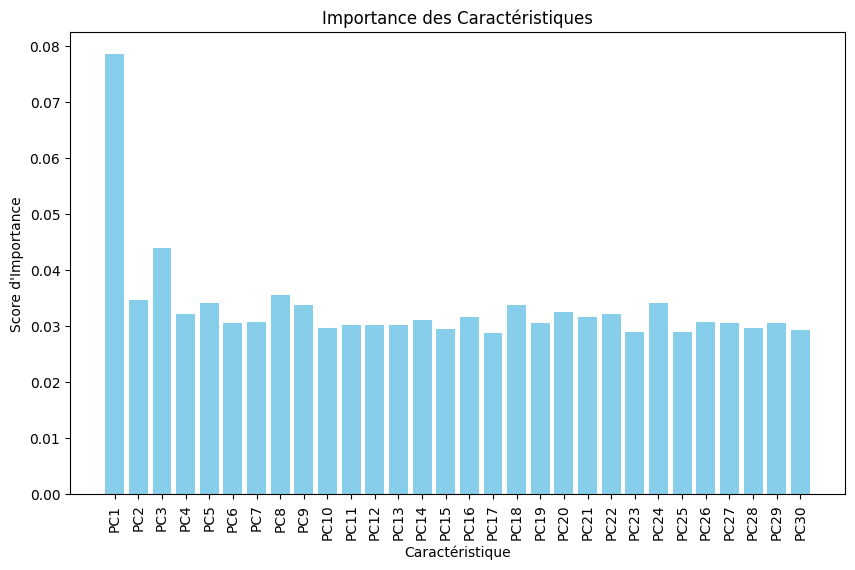

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.title("Importance des Caractéristiques")
plt.bar(range(len(feature_names)), importances, align="center", color="#87CEEB", label="Importance")
plt.xticks(range(len(feature_names)), feature_names, rotation=90)
plt.xlabel("Caractéristique")
plt.ylabel("Score d'Importance")
plt.show()

In [14]:
loadings = pca.components_.shape
# Obtenir les noms d'origine des colonnes
original_features = X.columns

# Créer un DataFrame pour visualiser les poids de chaque feature sur chaque composante
pca_df = pd.DataFrame(pca.components_, columns=original_features, index=feature_names)
print("Top features dans la composante PC19 :")
print(pca_df.loc["PC2"].sort_values(key=abs, ascending=False).head(5))
print("Top features dans la composante PC12 :")
print(pca_df.loc["PC7"].sort_values(key=abs, ascending=False).head(5))
print("Top features dans la composante PC11 :")
print(pca_df.loc["PC11"].sort_values(key=abs, ascending=False).head(5))
print("Top features dans la composante PC17(la plus basse) :")
print(pca_df.loc["PC17"].sort_values(key=abs, ascending=False).head(5))

Top features dans la composante PC19 :
elo_away    0.707495
elo_home    0.706560
B365A       0.005874
HS_avg      0.005577
AS_avg      0.005492
Name: PC2, dtype: float64
Top features dans la composante PC12 :
HF_avg    0.758148
AF_avg   -0.489893
AS_avg   -0.276916
HS_avg    0.250811
HY_avg    0.114710
Name: PC7, dtype: float64
Top features dans la composante PC11 :
AC_avg         0.915951
AST_avg       -0.287229
AS_avg        -0.219045
FTAG_avg      -0.152711
H2H_matches   -0.039923
Name: PC11, dtype: float64
Top features dans la composante PC17(la plus basse) :
FTHG_avg    0.900719
HST_avg    -0.391253
B365D       0.111873
HS_avg      0.068768
HY_avg      0.064824
Name: PC17, dtype: float64
